In [1]:
'''
    __author__=
    the code is written for jupyter and SLURM (HCC-UNL)
    setting up environment for this is challenging
    1. first create conda environment and follow HCC-UNL tutorial
    2. Load environments in $WORK rather than $HOME
        @TODO: make a script to create the environment and load jupyter environment
    3. Install theano and mkdir .theano directory with chmod ug+w permission at $HOME/.theano
    
    Now about the code
    
    code should be tested for SNR, SNN, Modulation and other different cases
    The full code will be written after it works on the GPU 
    
    challenge was in creating the environment ---- 80% successful
    CHECKING FOR GPU ENVIRONMENT, if this works
    
    theano, tensorflow/CUDNN libraries are different
    please check os.environ
'''

'''
, \
dnn.include_path=/util/opt/cuda/10/include, \
dnn.library_path=/util/opt/cuda/10/lib64
'''
dnn_include='/util/opt/cudnn/v5/include'
dnn_lib='/util/opt/cudnn/v5/cuda/lib64'

import os, random

os.environ["KERAS_BACKEND"] = "theano"
os.environ["THEANO_FLAGS"] = "base_compiledir=/work/tellab/subharthib/, \
mode=FAST_RUN, device=cuda0, \
optimizer_including=cudnn, \
floatX=float32, \
dnn.include_path=/util/opt/cuda/9.2/include, \
dnn.library_path=/util/opt/cuda/9.2/lib64, \
dnn.bin_path=/util/opt/cuda/9.2/lib64"
import numpy as np

print('import successful numpy')
print('another import successful numpy')
import keras.models as models
print('keras utils')
from keras.utils import np_utils, Sequence



import keras.backend as K
from time import time
from keras.layers.core import Reshape, Dense, Dropout, Activation, Flatten

from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import  random, sys, keras
print('all modules loaded successfully')

import successful numpy
another import successful numpy


Using Theano backend.
/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7401 on context None
Mapped name None to device cuda0: Tesla K20m (0000:03:00.0)


keras utils
all modules loaded successfully


In [2]:
# keras hard setup

K.set_image_data_format('channels_first')
num_validation_samples = 0
num_training_samples = 0
# snr values inside dataset
snr_val = np.arange(-20, 31)
modulation_lbls = ['OOK',
 '4ASK',
 '8ASK',
 'BPSK',
 'QPSK',
 '8PSK',
 '16PSK',
 '32PSK',
 '16APSK',
 '32APSK',
 '64APSK',
 '128APSK',
 '16QAM',
 '32QAM',
 '64QAM',
 '128QAM',
 '256QAM',
 'AM-SSB-WC',
 'AM-SSB-SC',
 'AM-DSB-WC',
 'AM-DSB-SC',
 'FM',
 'GMSK',
 'OQPSK']
sample_size = 2500
print("Modules loaded successfully..")

#os.chdir("..")
cwd = '/work/tellab/subharthib'
filename = cwd+'/2018.01/' +'GOLD_XYZ_OSC.0001_1024.hdf5'
print("Opening file at",filename)

Modules loaded successfully..
Opening file at /work/tellab/subharthib/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5


In [3]:
iq_mod = []
# 2555904
sample_size=2500
with h5py.File(filename, 'r') as f:
    # List all groups
    
    print("Keys: %s" % f.keys())
    n_samples = f['X'].shape[0]
    #sample_size = n_samples
    print(sample_size)
    num_training_samples = n_samples//2
    num_validation_samples = n_samples//2
    samp = random.sample(range(0, n_samples), sample_size)
    
    samp.sort()
    samp = np.asarray(samp, dtype=np.int32)
    
    iq_data_obj = f['X']
    iq_data = iq_data_obj[samp, :, :]
    print("I/Q data...")
    mod_data_obj = f['Y']
    mod_data = mod_data_obj[samp, :]
    print("mod data..")
    snr_data_obj = f['Z']
    snr_data = snr_data_obj[samp, :]
    print("snr data..")
print("Data loaded successfully from file ",filename)    
    # Get the data
r, c= np.where(mod_data==1)

Keys: <KeysViewHDF5 ['X', 'Y', 'Z']>
2500
I/Q data...
mod data..
snr data..
Data loaded successfully from file  /work/tellab/subharthib/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5


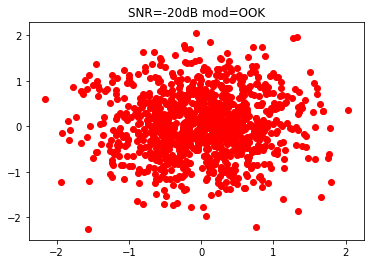

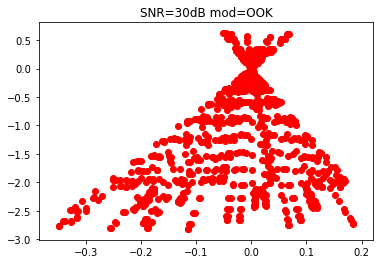

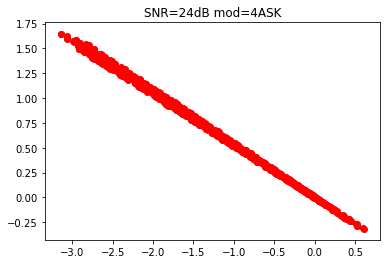

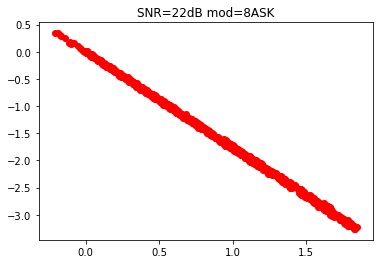

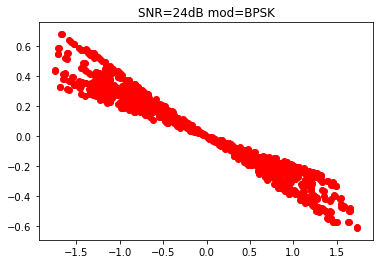

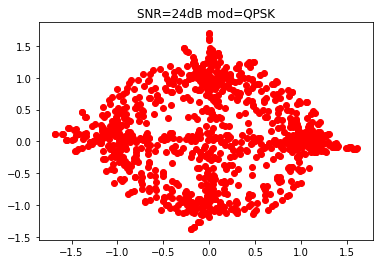

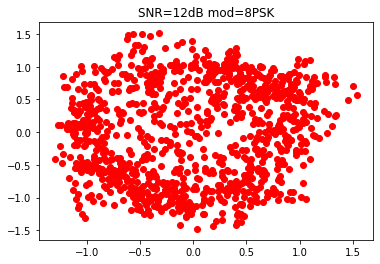

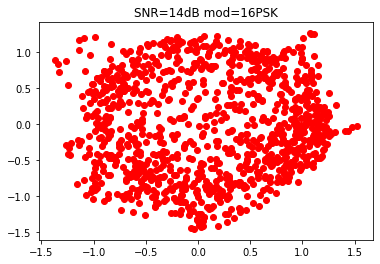

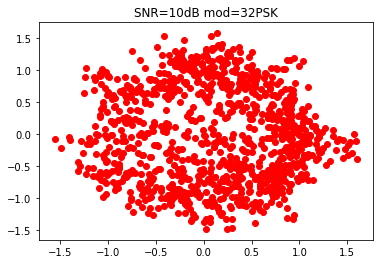

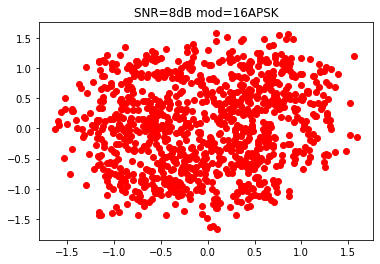

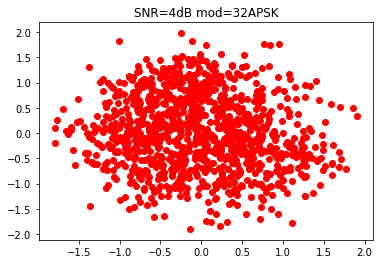

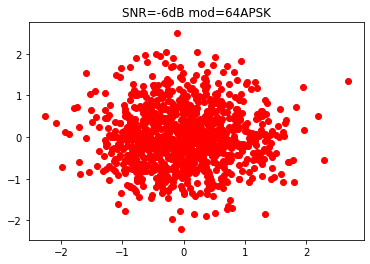

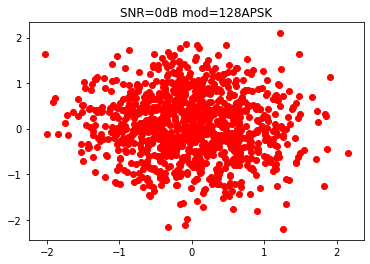

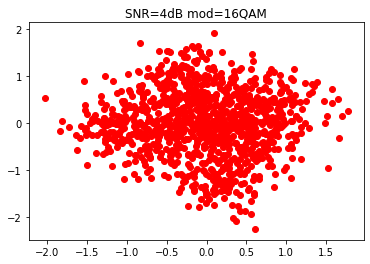

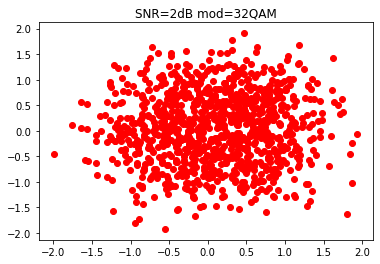

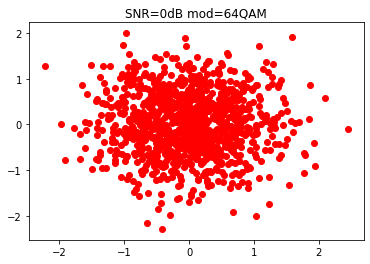

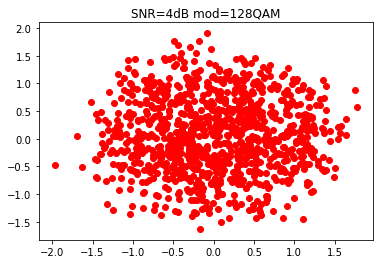

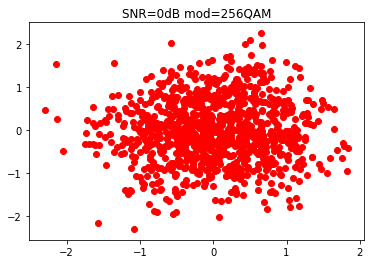

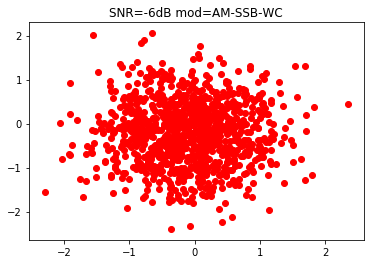

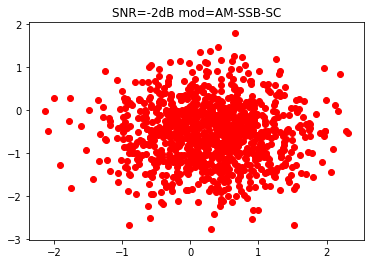

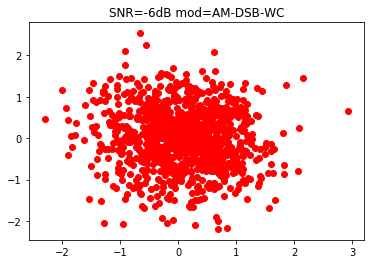

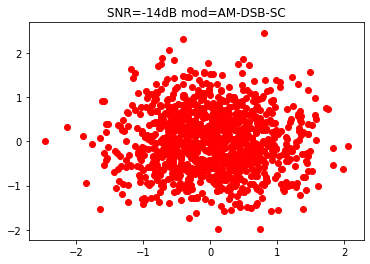

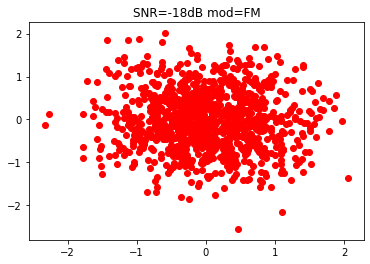

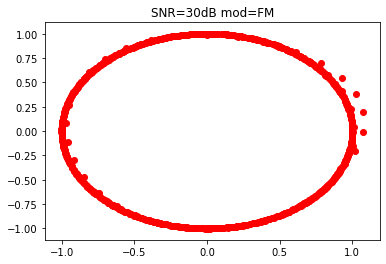

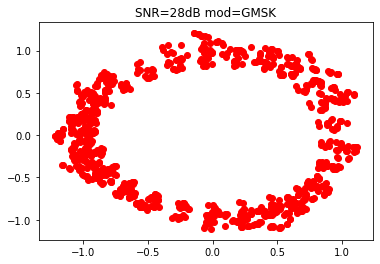

In [4]:
for j in range(0, sample_size):
    iq_mod.append(modulation_lbls[c[r[j]]])
    
for i in range (0, 2500, 100):
    X = iq_data[i, :, 0]
    Y = iq_data[i, :, 1]
    title = 'SNR='+str(snr_data[i][0])+'dB'+' mod='+str(iq_mod[i])
    plt.title(title)
    plt.scatter(X, Y, color='red')
    
    plt.show()

# partition the data in train and test

In [5]:
# partition the data in train and test
    
n_train = round(sample_size * 0.5)
train_idx = np.random.choice(range(0, sample_size), size=n_train, replace=False)
test_idx = list(set(range(0,sample_size))-set(train_idx))
iq_data=iq_data.reshape(sample_size, 2, iq_data.shape[1])
X_train = iq_data[train_idx]
X_test = iq_data[test_idx]

# some hard coded trick to reshape array
in_shp = X_train.shape[1:]
in_shp = list(in_shp)

iq_mod = np.asarray(iq_mod, dtype='<S20')
iq_mod = iq_mod.reshape(sample_size,1)
Y_train = mod_data[train_idx]
Y_test = mod_data[test_idx]

print('data loaded with size', X_train.shape, Y_train.shape)

data loaded with size (1250, 2, 1024) (1250, 24)


In [6]:
def create_mod_class(lbls, mod_sparse):
    '''
        this function creates sparse matrix
        to the labels
    '''
    pass

In [7]:
def idx_for_snr(snr_val, data):
    '''
        finding ids for that snr values to train on that 
        or series of snrs
        values of snr can be 
        snr_val \in [-20, 30]
    '''
    if len(snr_val) == 0:
        assert 'please insert a snr_val'
        return -1
    elif len(snr_val) == 1:
        return np.where(data, snr_val)
    else:
        
        idx = np.argwhere((data >= snr_val[1]) & (data <= snr_val[-1]))
        return idx

In [8]:
def create_examples(n_samples, data, ids):
    '''
        this code selects how many radio samples 
        some one needs for working on this model
        
        n_samples can be 8, 16, 32, 64....1024
    '''
    n_examples = data.shape[2]
    interval = n_examples//n_samples
    cur_data = data[:, :, 1:-1:interval]
    return cur_data

In [9]:
def generator(db, indices, batch_size=128, is_train=True, aug=None):
    
    while True:
        #np.random.shuffle(indices)
        for i in range(0, len(indices), batch_size):
            
            batch_indices = indices[i:i+batch_size]
            #batch_indices.sort()

            by = db["Y"][batch_indices,:]
            bx = db["X"][batch_indices,:,:]
            
            bx = bx.reshape(bx.shape[0], 2, bx.shape[1])
            
            
          #  print('t = ', t1-t0, i)
            #if is_train:

                
             #   if aug is not None:
              #      bx,by = next(aug.flow(bx,by,batch_size))

            yield (bx,by)   

In [10]:
## model details

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape([1]+in_shp, input_shape=in_shp))

model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(32, (1, 3), padding='valid', activation="relu", name="conv1",
                 kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2",
                 kernel_initializer='glorot_uniform'))
print("second conv2d")
model.add(Dropout(dr))
model.add(Flatten())
print('flattened')

#@TODO: dense environment is currently wrong
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', 
                name="dense1"))
print('dense done')
model.add(Dropout(dr))
model.add(Dense( len(modulation_lbls), kernel_initializer='he_normal', 
                name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(modulation_lbls)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

second conv2d
flattened
dense done
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 1, 2, 1024)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 2, 1028)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 2, 1026)       128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 2, 1026)       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 2, 1030)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 80, 1, 1028)       15440     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80, 1

In [12]:
# Set up some params 
nb_epoch = 30     # number of epochs to train on
batch_size = 1024 # training batch size
n_runs_train = 200000
sample_size=n_runs_train
n_train = round(sample_size * 0.75)
train_idx = np.random.choice(range(0, 2*num_validation_samples), size=n_train, replace=False)#list(range(0, n_runs_train))
#test_idx = list(range(2000, 3000))
train_idx.sort()

test_idx = np.random.choice(range(0, 2*num_validation_samples), size=1250, replace=False)
test_idx.sort()
#
#test_idx = list(set(range(0,sample_size))-set(train_idx))
print(num_validation_samples, num_training_samples)
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_SNN_1_0_1.wts.h5'
#history=model.fit(X_train, Y_train)
file_ref = h5py.File(filename, 'r')

# list(range(n_runs_train,n_runs_train+100000))
history = model.fit_generator(generator=generator(file_ref, train_idx, batch_size=batch_size, is_train=True),
    epochs=nb_epoch,
    steps_per_epoch=(len(train_idx) // batch_size),
    verbose=1,
    validation_data=generator(file_ref,test_idx , batch_size=batch_size, is_train=False),
    validation_steps=(len(test_idx) // batch_size)
    )

'''
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
'''
keras.models.save_model(model, os.path.join(cwd, filepath))   
# we re-load the best weights once training is finished
model.load_weights(filepath)

1277952 1277952
Epoch 1/30
 11/146 [=>............................] - ETA: 10:07 - loss: 5.3907 ETA: 11:35 - loss:  - ETA: 9:28 - loss: 6.4399 - ETA: 9:03 - loss: 7.2976

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.865947). Check your callbacks.
  % delta_t_median)


 12/146 [=>............................] - ETA: 8:44 - loss: 7.9933

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.748485). Check your callbacks.
  % delta_t_median)


 13/146 [=>............................] - ETA: 8:30 - loss: 8.5713

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.957518). Check your callbacks.
  % delta_t_median)


 15/146 [==>...........................] - ETA: 7:56 - loss: 9.4243

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.091963). Check your callbacks.
  % delta_t_median)


 18/146 [==>...........................] - ETA: 7:32 - loss: 10.2081

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.164937). Check your callbacks.
  % delta_t_median)


 20/146 [===>..........................] - ETA: 7:24 - loss: 9.8739 

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.166790). Check your callbacks.
  % delta_t_median)


 23/146 [===>..........................] - ETA: 6:58 - loss: 9.0395

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.092699). Check your callbacks.
  % delta_t_median)


 35/146 [======>.......................] - ETA: 6:03 - loss: 7.0253

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.105133). Check your callbacks.
  % delta_t_median)


 36/146 [======>.......................] - ETA: 5:59 - loss: 6.9167

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.179089). Check your callbacks.
  % delta_t_median)


 40/146 [=======>......................] - ETA: 5:38 - loss: 6.5407

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.002199). Check your callbacks.
  % delta_t_median)


 42/146 [=======>......................] - ETA: 5:29 - loss: 6.3798

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.002278). Check your callbacks.
  % delta_t_median)


 54/146 [==========>...................] - ETA: 4:41 - loss: 5.6732

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.207234). Check your callbacks.
  % delta_t_median)


 55/146 [==========>...................] - ETA: 4:37 - loss: 5.6279

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.225510). Check your callbacks.
  % delta_t_median)


 57/146 [==========>...................] - ETA: 4:28 - loss: 5.5435

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.335447). Check your callbacks.
  % delta_t_median)


 60/146 [===========>..................] - ETA: 4:20 - loss: 5.4269

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.293545). Check your callbacks.
  % delta_t_median)


 61/146 [===========>..................] - ETA: 4:15 - loss: 5.3904

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.183609). Check your callbacks.
  % delta_t_median)


 64/146 [============>.................] - ETA: 4:04 - loss: 5.2862- ETA: 4:07 - loss: 5.319

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.084446). Check your callbacks.
  % delta_t_median)


 65/146 [============>.................] - ETA: 4:00 - loss: 5.2536

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.031219). Check your callbacks.
  % delta_t_median)


 67/146 [============>.................] - ETA: 3:51 - loss: 5.1914

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.871177). Check your callbacks.
  % delta_t_median)


 68/146 [============>.................] - ETA: 3:47 - loss: 5.1626

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.554038). Check your callbacks.
  % delta_t_median)


 70/146 [=============>................] - ETA: 3:40 - loss: 5.1081

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.891187). Check your callbacks.
  % delta_t_median)


 71/146 [=============>................] - ETA: 3:36 - loss: 5.0818

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.003823). Check your callbacks.
  % delta_t_median)


 72/146 [=============>................] - ETA: 3:33 - loss: 5.0562

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.897422). Check your callbacks.
  % delta_t_median)


 79/146 [===============>..............] - ETA: 3:09 - loss: 4.8947

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.030738). Check your callbacks.
  % delta_t_median)


 81/146 [===============>..............] - ETA: 3:06 - loss: 4.8534

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.101759). Check your callbacks.
  % delta_t_median)


 84/146 [================>.............] - ETA: 3:02 - loss: 4.7949

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.758601). Check your callbacks.
  % delta_t_median)


 87/146 [================>.............] - ETA: 2:57 - loss: 4.7402

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.311768). Check your callbacks.
  % delta_t_median)


 99/146 [===================>..........] - ETA: 2:26 - loss: 4.5556

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.554668). Check your callbacks.
  % delta_t_median)


116/146 [======================>.......] - ETA: 1:35 - loss: 4.3656- ETA: 1:38 - loss: 4.375

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.287563). Check your callbacks.
  % delta_t_median)


117/146 [=======================>......] - ETA: 1:32 - loss: 4.3559

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.797785). Check your callbacks.
  % delta_t_median)


118/146 [=======================>......] - ETA: 1:29 - loss: 4.3464

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.132372). Check your callbacks.
  % delta_t_median)


120/146 [=======================>......] - ETA: 1:22 - loss: 4.3278

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.181440). Check your callbacks.
  % delta_t_median)


124/146 [========================>.....] - ETA: 1:10 - loss: 4.2926

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.162869). Check your callbacks.
  % delta_t_median)


125/146 [========================>.....] - ETA: 1:07 - loss: 4.2842

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.226292). Check your callbacks.
  % delta_t_median)


127/146 [=========================>....] - ETA: 1:01 - loss: 4.2677

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.043556). Check your callbacks.
  % delta_t_median)


128/146 [=========================>....] - ETA: 58s - loss: 4.2596 

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.063443). Check your callbacks.
  % delta_t_median)


129/146 [=========================>....] - ETA: 55s - loss: 4.2518

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.106506). Check your callbacks.
  % delta_t_median)


132/146 [==========================>...] - ETA: 45s - loss: 4.2289

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.016089). Check your callbacks.
  % delta_t_median)


134/146 [==========================>...] - ETA: 38s - loss: 4.2141

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.923480). Check your callbacks.
  % delta_t_median)


137/146 [===========================>..] - ETA: 29s - loss: 4.1930

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.139046). Check your callbacks.
  % delta_t_median)


140/146 [===========================>..] - ETA: 19s - loss: 4.1728

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.006980). Check your callbacks.
  % delta_t_median)


141/146 [===========================>..] - ETA: 16s - loss: 4.1662

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.589012). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 476s 3s/step - loss: 4.1350 - val_loss: 3.1682
Epoch 2/30
  1/146 [..............................] - ETA: 19s - loss: 3.2477

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.850290). Check your callbacks.
  % delta_t_median)


  2/146 [..............................] - ETA: 2:38 - loss: 3.1995

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.292445). Check your callbacks.
  % delta_t_median)


  4/146 [..............................] - ETA: 4:02 - loss: 3.1750

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.638667). Check your callbacks.
  % delta_t_median)


  5/146 [>.............................] - ETA: 3:52 - loss: 3.1686

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.661486). Check your callbacks.
  % delta_t_median)


  6/146 [>.............................] - ETA: 3:56 - loss: 3.1636

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.755888). Check your callbacks.
  % delta_t_median)


 11/146 [=>............................] - ETA: 5:01 - loss: 3.1872

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.026066). Check your callbacks.
  % delta_t_median)


 13/146 [=>............................] - ETA: 5:18 - loss: 3.1944

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.475859). Check your callbacks.
  % delta_t_median)


 14/146 [=>............................] - ETA: 5:24 - loss: 3.1934

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.625632). Check your callbacks.
  % delta_t_median)


 15/146 [==>...........................] - ETA: 5:26 - loss: 3.1912

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.702477). Check your callbacks.
  % delta_t_median)


 16/146 [==>...........................] - ETA: 5:33 - loss: 3.1891

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.771437). Check your callbacks.
  % delta_t_median)


 18/146 [==>...........................] - ETA: 5:39 - loss: 3.1844

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.925884). Check your callbacks.
  % delta_t_median)


 19/146 [==>...........................] - ETA: 5:40 - loss: 3.1820

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.045233). Check your callbacks.
  % delta_t_median)


 22/146 [===>..........................] - ETA: 5:37 - loss: 3.1748

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.869208). Check your callbacks.
  % delta_t_median)


 24/146 [===>..........................] - ETA: 5:42 - loss: 3.1708

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.047641). Check your callbacks.
  % delta_t_median)


 25/146 [====>.........................] - ETA: 5:46 - loss: 3.1689

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.827994). Check your callbacks.
  % delta_t_median)


 28/146 [====>.........................] - ETA: 5:52 - loss: 3.1647

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.100836). Check your callbacks.
  % delta_t_median)


 29/146 [====>.........................] - ETA: 5:51 - loss: 3.1635

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.577491). Check your callbacks.
  % delta_t_median)


 32/146 [=====>........................] - ETA: 5:47 - loss: 3.1602

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.149380). Check your callbacks.
  % delta_t_median)


 33/146 [=====>........................] - ETA: 5:45 - loss: 3.1595

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.941500). Check your callbacks.
  % delta_t_median)


 35/146 [======>.......................] - ETA: 5:43 - loss: 3.1582

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.317623). Check your callbacks.
  % delta_t_median)


 38/146 [======>.......................] - ETA: 5:42 - loss: 3.1565

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.342326). Check your callbacks.
  % delta_t_median)


 42/146 [=======>......................] - ETA: 5:29 - loss: 3.1552

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.336724). Check your callbacks.
  % delta_t_median)


 43/146 [=======>......................] - ETA: 5:23 - loss: 3.1549

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.385738). Check your callbacks.
  % delta_t_median)


 45/146 [========>.....................] - ETA: 5:21 - loss: 3.154 - ETA: 5:19 - loss: 3.1546

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.430457). Check your callbacks.
  % delta_t_median)


 46/146 [========>.....................] - ETA: 5:19 - loss: 3.1546

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.264944). Check your callbacks.
  % delta_t_median)


 47/146 [========>.....................] - ETA: 5:22 - loss: 3.1545

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.143840). Check your callbacks.
  % delta_t_median)


 50/146 [=========>....................] - ETA: 5:14 - loss: 3.1541

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.893542). Check your callbacks.
  % delta_t_median)


 51/146 [=========>....................] - ETA: 5:12 - loss: 3.1542

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.642422). Check your callbacks.
  % delta_t_median)


 58/146 [==========>...................] - ETA: 4:45 - loss: 3.1551

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.965627). Check your callbacks.
  % delta_t_median)


 60/146 [===========>..................] - ETA: 4:36 - loss: 3.1555

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.313984). Check your callbacks.
  % delta_t_median)


 61/146 [===========>..................] - ETA: 4:30 - loss: 3.1557

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.607341). Check your callbacks.
  % delta_t_median)


 63/146 [===========>..................] - ETA: 4:17 - loss: 3.1561

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.690494). Check your callbacks.
  % delta_t_median)


 66/146 [============>.................] - ETA: 4:02 - loss: 3.1571

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.605144). Check your callbacks.
  % delta_t_median)


 69/146 [=============>................] - ETA: 3:49 - loss: 3.1581

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.517536). Check your callbacks.
  % delta_t_median)


 70/146 [=============>................] - ETA: 3:44 - loss: 3.1585

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258994). Check your callbacks.
  % delta_t_median)


 81/146 [===============>..............] - ETA: 3:19 - loss: 3.1619

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.633347). Check your callbacks.
  % delta_t_median)


 82/146 [===============>..............] - ETA: 3:17 - loss: 3.1623

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.424791). Check your callbacks.
  % delta_t_median)


 83/146 [================>.............] - ETA: 3:14 - loss: 3.1626

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.633346). Check your callbacks.
  % delta_t_median)


 90/146 [=================>............] - ETA: 2:58 - loss: 3.1650- ETA: 3:07 - loss: 3.

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.450743). Check your callbacks.
  % delta_t_median)


 91/146 [=================>............] - ETA: 2:55 - loss: 3.1654

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.278046). Check your callbacks.
  % delta_t_median)


 92/146 [=================>............] - ETA: 2:52 - loss: 3.1657

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (3.120898). Check your callbacks.
  % delta_t_median)


 93/146 [==================>...........] - ETA: 2:47 - loss: 3.1660

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.533392). Check your callbacks.
  % delta_t_median)


123/146 [========================>.....] - ETA: 1:12 - loss: 3.1790

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.327036). Check your callbacks.
  % delta_t_median)


126/146 [========================>.....] - ETA: 1:02 - loss: 3.1804

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.327978). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 468s 3s/step - loss: 3.1891 - val_loss: 3.2259
Epoch 3/30
 17/146 [==>...........................] - ETA: 6:56 - loss: 3.1914

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.487960). Check your callbacks.
  % delta_t_median)


 22/146 [===>..........................] - ETA: 6:49 - loss: 3.1787

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.205767). Check your callbacks.
  % delta_t_median)


 23/146 [===>..........................] - ETA: 6:36 - loss: 3.1766

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.634625). Check your callbacks.
  % delta_t_median)


 59/146 [===========>..................] - ETA: 3:40 - loss: 3.1577

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238760). Check your callbacks.
  % delta_t_median)


 63/146 [===========>..................] - ETA: 3:29 - loss: 3.1584

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241276). Check your callbacks.
  % delta_t_median)


 75/146 [==============>...............] - ETA: 2:45 - loss: 3.1618

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.413601). Check your callbacks.
  % delta_t_median)


 76/146 [==============>...............] - ETA: 2:41 - loss: 3.1621

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223888). Check your callbacks.
  % delta_t_median)


112/146 [======================>.......] - ETA: 1:09 - loss: 3.1749

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.422910). Check your callbacks.
  % delta_t_median)


118/146 [=======================>......] - ETA: 58s - loss: 3.177 - ETA: 55s - loss: 3.1775

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.401604). Check your callbacks.
  % delta_t_median)


119/146 [=======================>......] - ETA: 53s - loss: 3.1779

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.399341). Check your callbacks.
  % delta_t_median)


127/146 [=========================>....] - ETA: 36s - loss: 3.1813

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.401663). Check your callbacks.
  % delta_t_median)


130/146 [=========================>....] - ETA: 30s - loss: 3.1824

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.409385). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 267s 2s/step - loss: 3.1891 - val_loss: 3.1687
Epoch 4/30
 29/146 [====>.........................] - ETA: 3:05 - loss: 3.1620

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.443973). Check your callbacks.
  % delta_t_median)


 72/146 [=============>................] - ETA: 2:27 - loss: 3.1588

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.372262). Check your callbacks.
  % delta_t_median)


 73/146 [==============>...............] - ETA: 2:25 - loss: 3.1592

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.385917). Check your callbacks.
  % delta_t_median)


107/146 [====================>.........] - ETA: 1:32 - loss: 3.1708

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.430310). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 377s 3s/step - loss: 3.1869 - val_loss: 3.2231
Epoch 5/30
  1/146 [..............................] - ETA: 34s - loss: 3.2412

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.391898). Check your callbacks.
  % delta_t_median)


  2/146 [..............................] - ETA: 3:25 - loss: 3.2405

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.209337). Check your callbacks.
  % delta_t_median)


 22/146 [===>..........................] - ETA: 6:15 - loss: 3.1815

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.097689). Check your callbacks.
  % delta_t_median)


 29/146 [====>.........................] - ETA: 5:30 - loss: 3.1632

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.727222). Check your callbacks.
  % delta_t_median)


 51/146 [=========>....................] - ETA: 4:19 - loss: 3.1348

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.231436). Check your callbacks.
  % delta_t_median)


 52/146 [=========>....................] - ETA: 4:19 - loss: 3.1359

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.426970). Check your callbacks.
  % delta_t_median)


 56/146 [==========>...................] - ETA: 4:08 - loss: 3.1379

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.833209). Check your callbacks.
  % delta_t_median)


 77/146 [==============>...............] - ETA: 2:51 - loss: 3.1480

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232746). Check your callbacks.
  % delta_t_median)


 80/146 [===============>..............] - ETA: 2:43 - loss: 3.1495

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.414540). Check your callbacks.
  % delta_t_median)


 81/146 [===============>..............] - ETA: 2:40 - loss: 3.1500

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233237). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 321s 2s/step - loss: 3.1789 - val_loss: 3.1693
Epoch 6/30
 67/146 [============>.................] - ETA: 2:33 - loss: 3.1344

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.314528). Check your callbacks.
  % delta_t_median)


 70/146 [=============>................] - ETA: 2:26 - loss: 3.1360

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.309417). Check your callbacks.
  % delta_t_median)


 98/146 [===================>..........] - ETA: 1:43 - loss: 3.1541

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.025375). Check your callbacks.
  % delta_t_median)


 99/146 [===================>..........] - ETA: 1:41 - loss: 3.1546

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.363307). Check your callbacks.
  % delta_t_median)


103/146 [====================>.........] - ETA: 1:30 - loss: 3.1565

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412624). Check your callbacks.
  % delta_t_median)


120/146 [=======================>......] - ETA: 50s - loss: 3.1644

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.383117). Check your callbacks.
  % delta_t_median)


125/146 [========================>.....] - ETA: 40s - loss: 3.1666

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.697876). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 262s 2s/step - loss: 3.1759 - val_loss: 3.2189
Epoch 7/30
  3/146 [..............................] - ETA: 1:48 - loss: 3.2346

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.756925). Check your callbacks.
  % delta_t_median)


  4/146 [..............................] - ETA: 1:55 - loss: 3.2340

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.406624). Check your callbacks.
  % delta_t_median)


 29/146 [====>.........................] - ETA: 1:54 - loss: 3.1684

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408801). Check your callbacks.
  % delta_t_median)


 30/146 [=====>........................] - ETA: 1:53 - loss: 3.1663

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410664). Check your callbacks.
  % delta_t_median)


 54/146 [==========>...................] - ETA: 1:30 - loss: 3.1439

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.417972). Check your callbacks.
  % delta_t_median)


 58/146 [==========>...................] - ETA: 1:28 - loss: 3.1465

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.420552). Check your callbacks.
  % delta_t_median)


 60/146 [===========>..................] - ETA: 1:26 - loss: 3.1469

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.423873). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 239s 2s/step - loss: 3.1840 - val_loss: 3.1697
Epoch 8/30
 29/146 [====>.........................] - ETA: 4:44 - loss: 3.1742

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408913). Check your callbacks.
  % delta_t_median)


 30/146 [=====>........................] - ETA: 4:44 - loss: 3.1724

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.409181). Check your callbacks.
  % delta_t_median)


111/146 [=====================>........] - ETA: 1:18 - loss: 3.1702

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.672146). Check your callbacks.
  % delta_t_median)


137/146 [===========================>..] - ETA: 19s - loss: 3.1789

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.521243). Check your callbacks.
  % delta_t_median)


141/146 [===========================>..] - ETA: 10s - loss: 3.1803

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.516353). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 319s 2s/step - loss: 3.1820 - val_loss: 3.2141
Epoch 9/30
 32/146 [=====>........................] - ETA: 2:25 - loss: 3.1738

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.429664). Check your callbacks.
  % delta_t_median)


 33/146 [=====>........................] - ETA: 2:23 - loss: 3.1723

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.429440). Check your callbacks.
  % delta_t_median)


 47/146 [========>.....................] - ETA: 1:59 - loss: 3.1637

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.769507). Check your callbacks.
  % delta_t_median)


 48/146 [========>.....................] - ETA: 1:57 - loss: 3.1627

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412857). Check your callbacks.
  % delta_t_median)


 51/146 [=========>....................] - ETA: 1:53 - loss: 3.1578

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412903). Check your callbacks.
  % delta_t_median)


 65/146 [============>.................] - ETA: 1:32 - loss: 3.1427- ETA: 1:36 - loss: 3.14

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.326239). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 169s 1s/step - loss: 3.1803 - val_loss: 3.1705
Epoch 10/30
 19/146 [==>...........................] - ETA: 2:23 - loss: 3.1951

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.395772). Check your callbacks.
  % delta_t_median)


 20/146 [===>..........................] - ETA: 2:34 - loss: 3.1982

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.395839). Check your callbacks.
  % delta_t_median)


 25/146 [====>.........................] - ETA: 3:08 - loss: 3.1975

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.577104). Check your callbacks.
  % delta_t_median)


 84/146 [================>.............] - ETA: 1:52 - loss: 3.1610

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.288676). Check your callbacks.
  % delta_t_median)


 88/146 [=================>............] - ETA: 1:49 - loss: 3.1630

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.762474). Check your callbacks.
  % delta_t_median)


 89/146 [=================>............] - ETA: 1:47 - loss: 3.1634

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.136311). Check your callbacks.
  % delta_t_median)


 92/146 [=================>............] - ETA: 1:42 - loss: 3.1647

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.143153). Check your callbacks.
  % delta_t_median)


 93/146 [==================>...........] - ETA: 1:41 - loss: 3.1652

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.457271). Check your callbacks.
  % delta_t_median)


113/146 [======================>.......] - ETA: 1:00 - loss: 3.1722

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408572). Check your callbacks.
  % delta_t_median)


116/146 [======================>.......] - ETA: 54s - loss: 3.1730

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.411611). Check your callbacks.
  % delta_t_median)


119/146 [=======================>......] - ETA: 49s - loss: 3.1731

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.713331). Check your callbacks.
  % delta_t_median)


138/146 [===========================>..] - ETA: 17s - loss: 3.1785

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.595332). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 338s 2s/step - loss: 3.1809 - val_loss: 3.2080
Epoch 11/30
 42/146 [=======>......................] - ETA: 6:16 - loss: 3.1672

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.708091). Check your callbacks.
  % delta_t_median)


 45/146 [========>.....................] - ETA: 6:08 - loss: 3.1661

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.705104). Check your callbacks.
  % delta_t_median)


 60/146 [===========>..................] - ETA: 5:20 - loss: 3.1466

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.540061). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 524s 4s/step - loss: 3.2164 - val_loss: 3.1695
Epoch 12/30
 23/146 [===>..........................] - ETA: 6:42 - loss: 3.1965

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.195184). Check your callbacks.
  % delta_t_median)


 26/146 [====>.........................] - ETA: 6:34 - loss: 3.1984

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.350320). Check your callbacks.
  % delta_t_median)


 31/146 [=====>........................] - ETA: 6:23 - loss: 3.1843

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (2.516984). Check your callbacks.
  % delta_t_median)


 32/146 [=====>........................] - ETA: 6:20 - loss: 3.1834

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.400344). Check your callbacks.
  % delta_t_median)


 38/146 [======>.......................] - ETA: 5:45 - loss: 3.1731

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.417222). Check your callbacks.
  % delta_t_median)


 43/146 [=======>......................] - ETA: 5:11 - loss: 3.156 - ETA: 5:03 - loss: 3.1551

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.734102). Check your callbacks.
  % delta_t_median)


 44/146 [========>.....................] - ETA: 4:56 - loss: 3.1532

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.402898). Check your callbacks.
  % delta_t_median)


 70/146 [=============>................] - ETA: 2:47 - loss: 3.0840

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.349043). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 253s 2s/step - loss: 3.1916 - val_loss: 3.1995
Epoch 13/30
146/146 [==============================] - 248s 2s/step - loss: 3.1867 - val_loss: 3.1673
Epoch 14/30
101/146 [===================>..........] - ETA: 1:35 - loss: 3.0808- ETA: 1:42 - loss: 

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.333978). Check your callbacks.
  % delta_t_median)


102/146 [===================>..........] - ETA: 1:33 - loss: 3.0816

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.332784). Check your callbacks.
  % delta_t_median)


109/146 [=====================>........] - ETA: 1:21 - loss: 3.0895

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (1.332924). Check your callbacks.
  % delta_t_median)


125/146 [========================>.....] - ETA: 48s - loss: 3.1006

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.410375). Check your callbacks.
  % delta_t_median)


128/146 [=========================>....] - ETA: 40s - loss: 3.1055

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.743794). Check your callbacks.
  % delta_t_median)


129/146 [=========================>....] - ETA: 38s - loss: 3.1056

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.730819). Check your callbacks.
  % delta_t_median)


133/146 [==========================>...] - ETA: 28s - loss: 3.1081

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.727931). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 310s 2s/step - loss: 3.1156 - val_loss: 3.1900
Epoch 15/30
146/146 [==============================] - 291s 2s/step - loss: 3.1189 - val_loss: 3.1527
Epoch 16/30
119/146 [=======================>......] - ETA: 54s - loss: 3.0727

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.428163). Check your callbacks.
  % delta_t_median)


123/146 [========================>.....] - ETA: 45s - loss: 3.0737

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.430789). Check your callbacks.
  % delta_t_median)


127/146 [=========================>....] - ETA: 36s - loss: 3.0699

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.416067). Check your callbacks.
  % delta_t_median)


130/146 [=========================>....] - ETA: 30s - loss: 3.0702

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.413321). Check your callbacks.
  % delta_t_median)


131/146 [=========================>....] - ETA: 28s - loss: 3.0695

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.412298). Check your callbacks.
  % delta_t_median)


134/146 [==========================>...] - ETA: 22s - loss: 3.0719

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.415806). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 271s 2s/step - loss: 3.0807 - val_loss: 3.1791
Epoch 17/30
146/146 [==============================] - 455s 3s/step - loss: 3.0623 - val_loss: 3.0756
Epoch 18/30
146/146 [==============================] - 614s 4s/step - loss: 3.0319 - val_loss: 3.1637
Epoch 19/30
146/146 [==============================] - 564s 4s/step - loss: 3.0235 - val_loss: 3.0814
Epoch 20/30
146/146 [==============================] - 285s 2s/step - loss: 3.1514 - val_loss: 3.0810
Epoch 21/30
  4/146 [..............................] - ETA: 1:59 - loss: 2.9934

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.406020). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 512s 4s/step - loss: 3.1884 - val_loss: 3.1511
Epoch 22/30
146/146 [==============================] - 575s 4s/step - loss: 3.0465 - val_loss: 2.8860
Epoch 23/30
146/146 [==============================] - 613s 4s/step - loss: 3.1763 - val_loss: 3.0409
Epoch 24/30
146/146 [==============================] - 507s 3s/step - loss: 2.9868 - val_loss: 3.1488
Epoch 25/30
  1/146 [..............................] - ETA: 35s - loss: 3.1380

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.785390). Check your callbacks.
  % delta_t_median)


  2/146 [..............................] - ETA: 1:29 - loss: 3.1420

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.426737). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 179s 1s/step - loss: 3.1192 - val_loss: 3.0098
Epoch 26/30
146/146 [==============================] - 177s 1s/step - loss: 3.1243 - val_loss: 3.1378
Epoch 27/30
  6/146 [>.............................] - ETA: 2:00 - loss: 3.1401

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.391972). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 505s 3s/step - loss: 3.1161 - val_loss: 3.0246
Epoch 28/30
146/146 [==============================] - 594s 4s/step - loss: 3.1103 - val_loss: 3.4809
Epoch 29/30
146/146 [==============================] - 291s 2s/step - loss: 3.1127 - val_loss: 3.0216
Epoch 30/30
  1/146 [..............................] - ETA: 29s - loss: 3.1564

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.834811). Check your callbacks.
  % delta_t_median)


  2/146 [..............................] - ETA: 1:30 - loss: 3.1558

/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.451452). Check your callbacks.
  % delta_t_median)


146/146 [==============================] - 180s 1s/step - loss: 3.1018 - val_loss: 3.1399


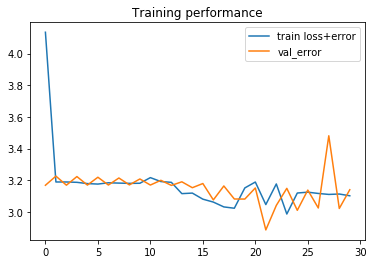

In [13]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [14]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

(1250, 1024, 2)
(1250, 24)


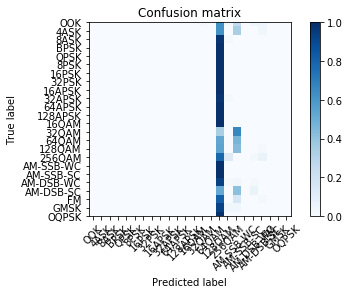

In [19]:
# Plot confusion matrix
print(X_test.shape)
print(Y_test.shape)

test_Y_hat = model.predict_generator(generator(file_ref, test_idx,\
                                               batch_size=batch_size, is_train=False),steps=len(test_idx)/batch_size)


conf = np.zeros([len(modulation_lbls),len(modulation_lbls)])
confnorm = np.zeros([len(modulation_lbls),len(modulation_lbls)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
    

for i in range(0,len(modulation_lbls)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=modulation_lbls)

X_test done
Y_test done
SNR =  -20  dB, Overall Accuracy:  0.0784313725490196
SNR =  -19  dB, Overall Accuracy:  nan
SNR =  -18  dB, Overall Accuracy:  0.019230769230769232
SNR =  -17  dB, Overall Accuracy:  nan
SNR =  -16  dB, Overall Accuracy:  0.05
SNR =  -15  dB, Overall Accuracy:  nan
SNR =  -14  dB, Overall Accuracy:  0.07272727272727272
SNR =  -13  dB, Overall Accuracy:  nan
SNR =  -12  dB, Overall Accuracy:  0.01818181818181818
SNR =  -11  dB, Overall Accuracy:  nan
SNR =  -10  dB, Overall Accuracy:  0.038461538461538464
SNR =  -9  dB, Overall Accuracy:  nan
SNR =  -8  dB, Overall Accuracy:  0.05263157894736842
SNR =  -7  dB, Overall Accuracy:  nan
SNR =  -6  dB, Overall Accuracy:  0.03389830508474576
SNR =  -5  dB, Overall Accuracy:  nan
SNR =  -4  dB, Overall Accuracy:  0.06779661016949153
SNR =  -3  dB, Overall Accuracy:  nan
SNR =  -2  dB, Overall Accuracy:  0.02631578947368421
SNR =  -1  dB, Overall Accuracy:  nan


/home/tellab/subharthib/.conda/envs/snn-custom-1.0/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


SNR =  0  dB, Overall Accuracy:  0.06521739130434782
SNR =  1  dB, Overall Accuracy:  nan
SNR =  2  dB, Overall Accuracy:  0.044444444444444446
SNR =  3  dB, Overall Accuracy:  nan
SNR =  4  dB, Overall Accuracy:  0.1276595744680851
SNR =  5  dB, Overall Accuracy:  nan
SNR =  6  dB, Overall Accuracy:  0.12244897959183673
SNR =  7  dB, Overall Accuracy:  nan
SNR =  8  dB, Overall Accuracy:  0.10869565217391304
SNR =  9  dB, Overall Accuracy:  nan
SNR =  10  dB, Overall Accuracy:  0.07017543859649122
SNR =  11  dB, Overall Accuracy:  nan
SNR =  12  dB, Overall Accuracy:  0.16666666666666666
SNR =  13  dB, Overall Accuracy:  nan
SNR =  14  dB, Overall Accuracy:  0.10714285714285714
SNR =  15  dB, Overall Accuracy:  nan
SNR =  16  dB, Overall Accuracy:  0.1
SNR =  17  dB, Overall Accuracy:  nan
SNR =  18  dB, Overall Accuracy:  0.11764705882352941
SNR =  19  dB, Overall Accuracy:  nan
SNR =  20  dB, Overall Accuracy:  0.05172413793103448
SNR =  21  dB, Overall Accuracy:  nan
SNR =  22  dB,

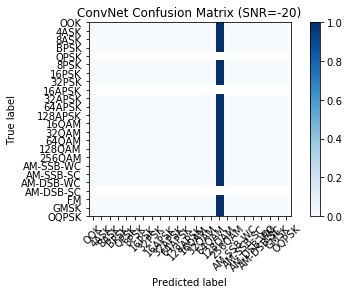

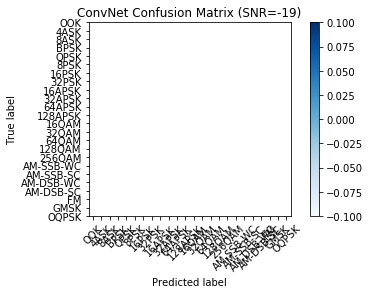

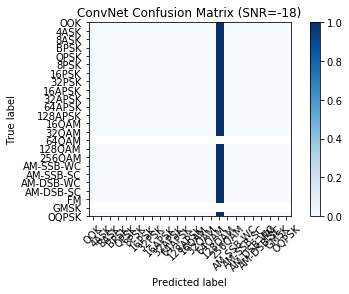

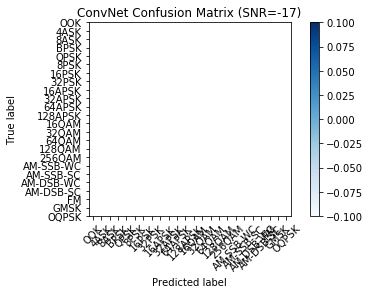

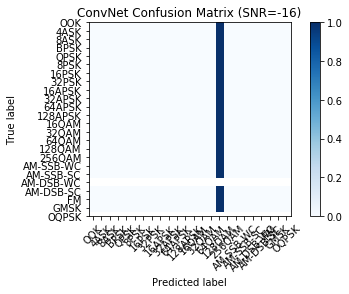

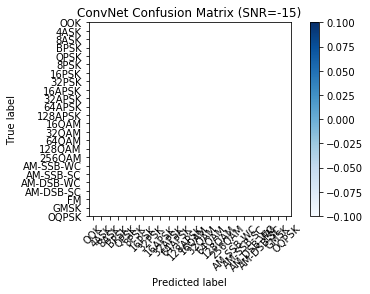

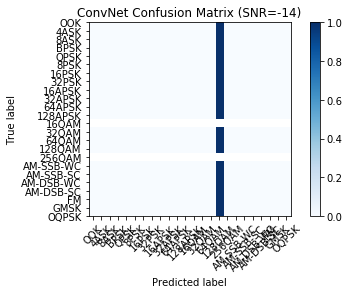

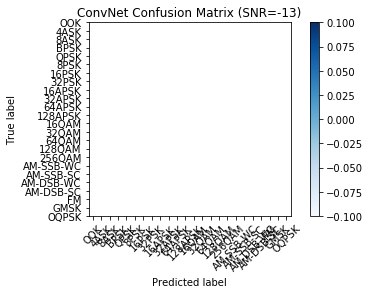

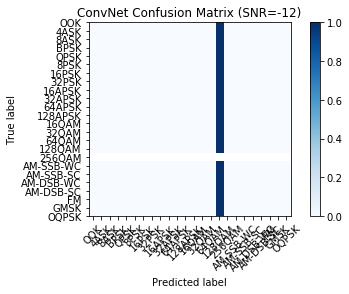

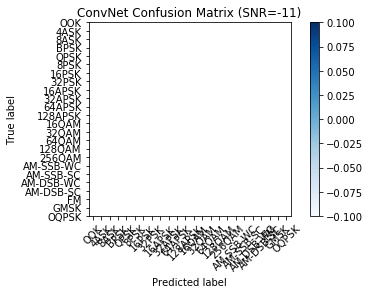

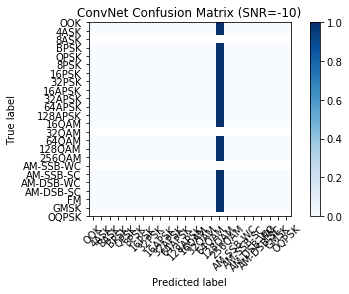

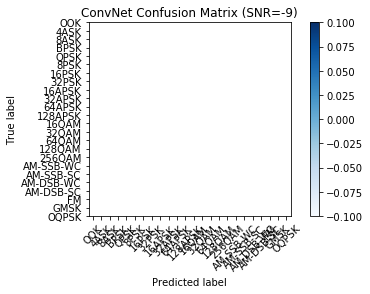

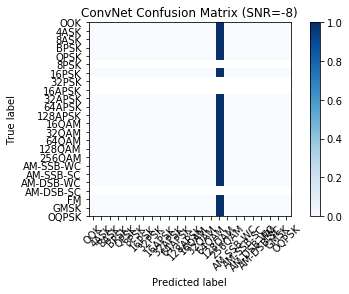

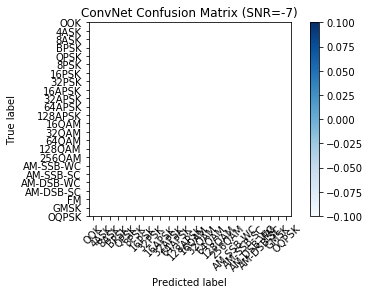

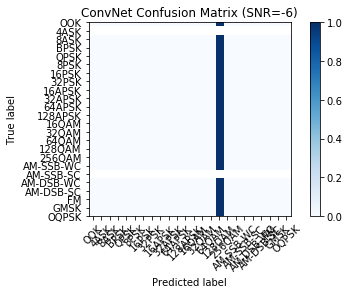

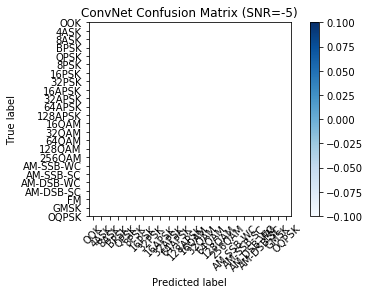

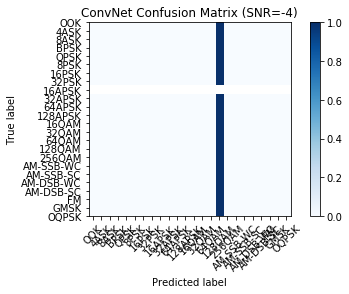

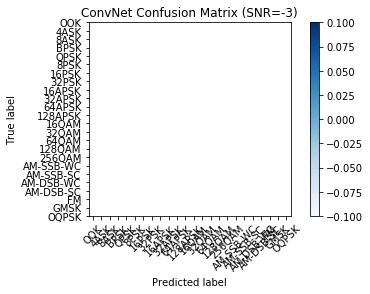

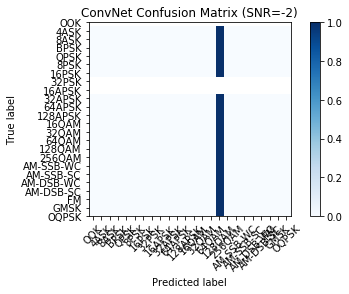

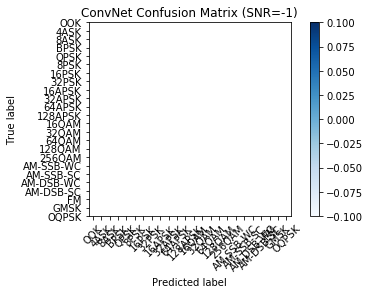

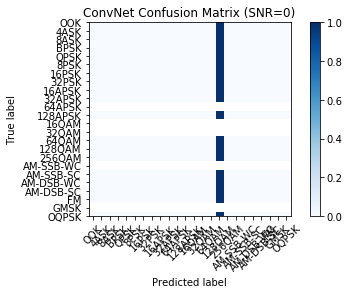

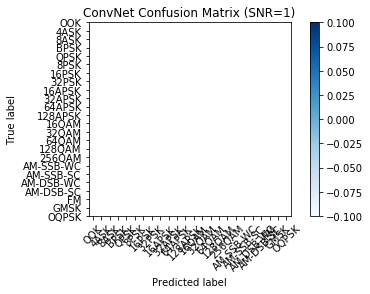

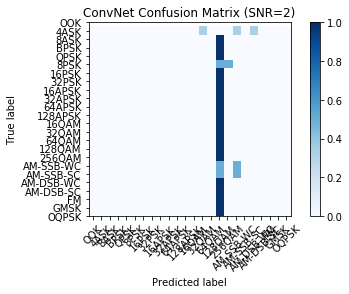

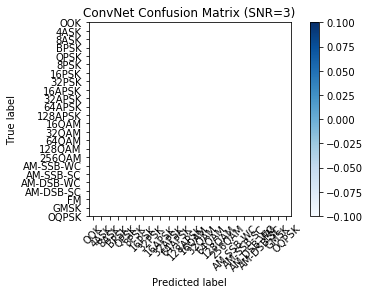

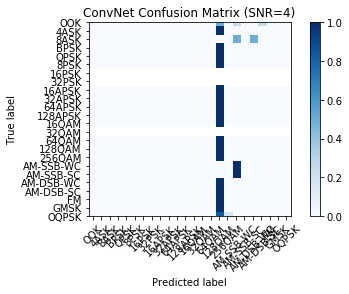

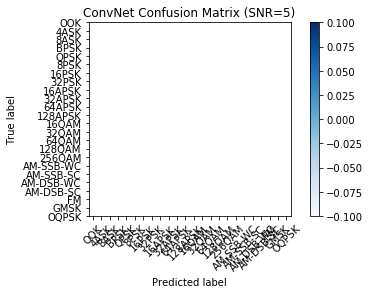

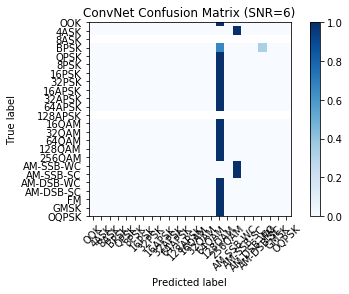

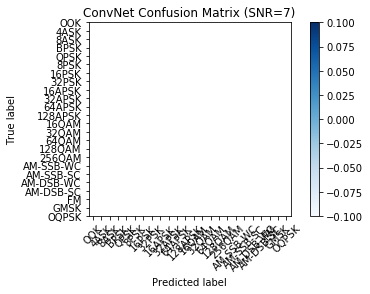

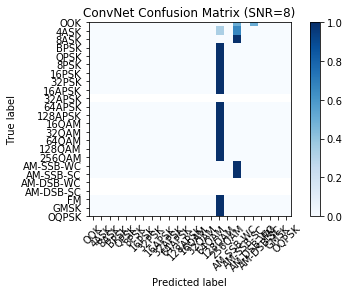

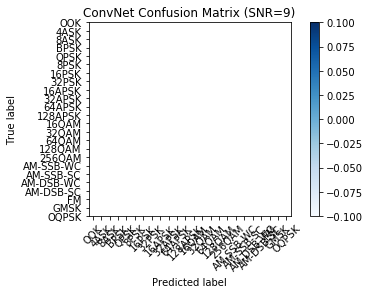

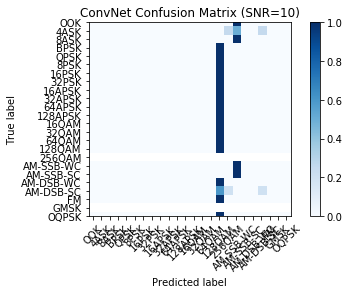

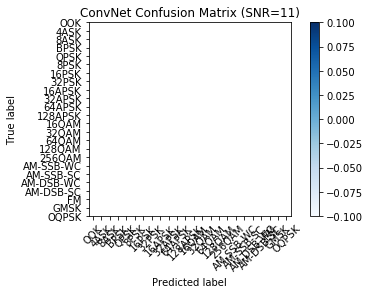

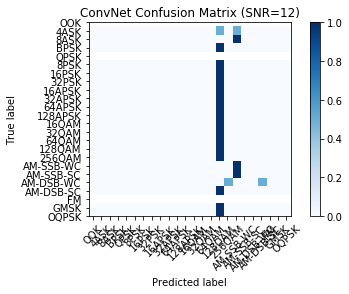

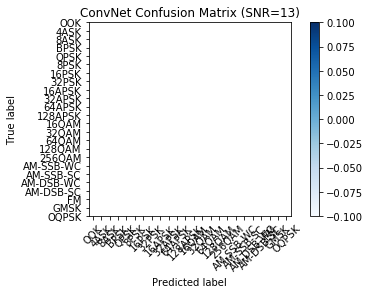

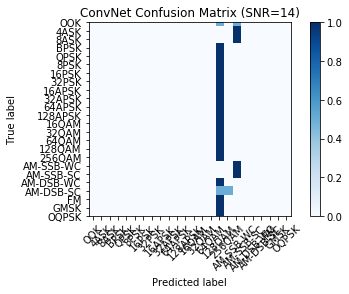

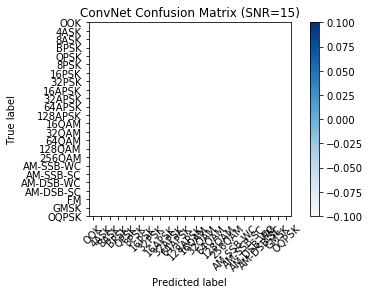

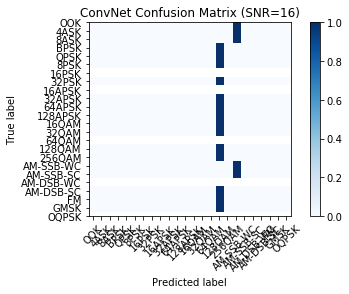

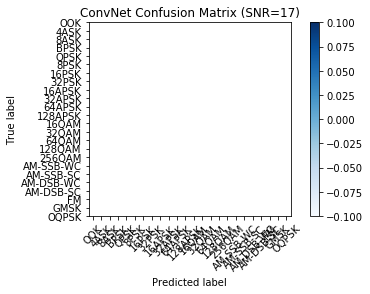

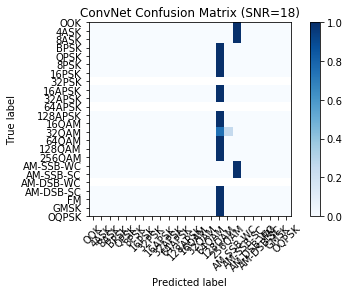

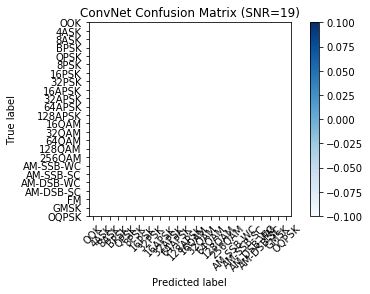

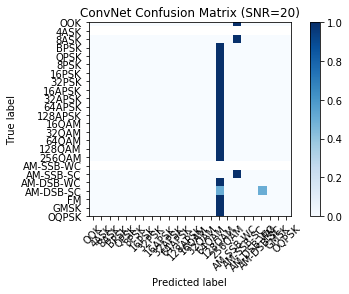

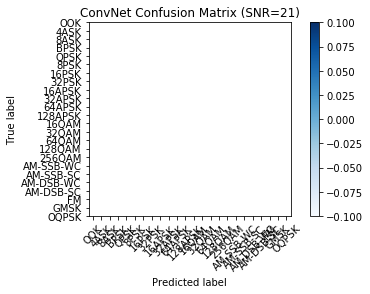

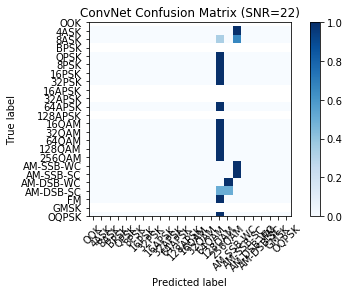

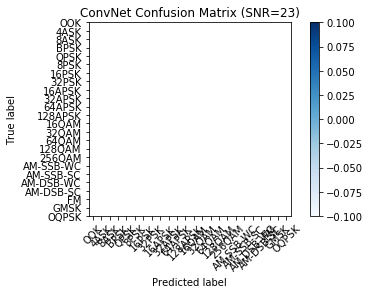

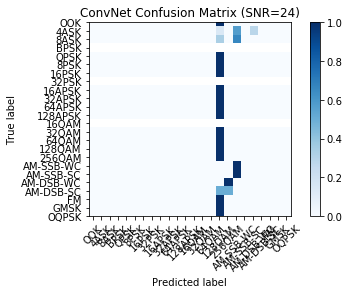

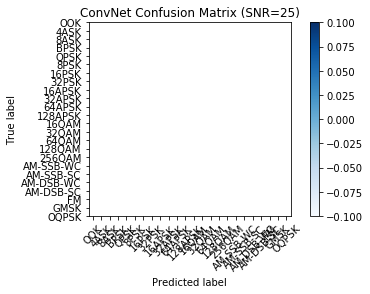

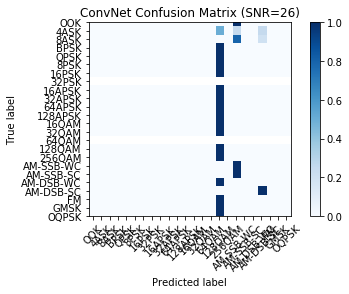

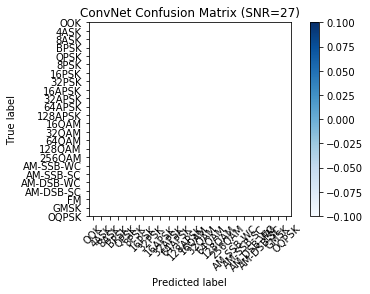

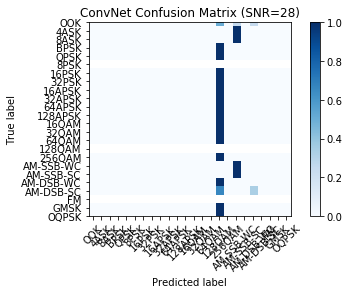

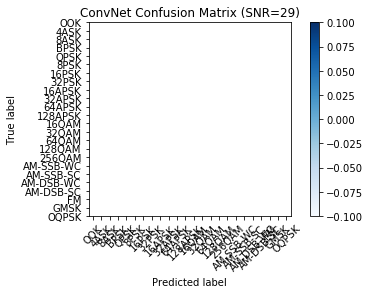

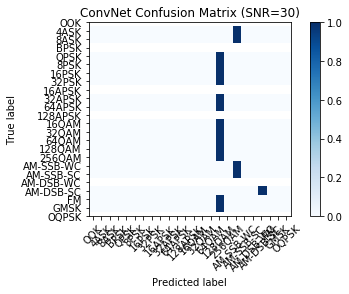

In [23]:
# Plot confusion matrix
#print(test_idx)
acc = {}
test_idx.sort()

# @TODO this code is stale. FIX IT
with h5py.File(filename, 'r') as f:
    
    snr_val_obj = f['Z']
    snr_data = snr_val_obj[test_idx]
    X_test_obj=f['X']
    X_test = X_test_obj[test_idx, :, :]
    print('X_test done')
    X_test = X_test.reshape(len(test_idx), 2, X_test.shape[1])
    Y_test_obj = f['Y']
    
    Y_test=Y_test_obj[test_idx, :]
    print('Y_test done')
    

for snr in snr_val:
    
    # extract classes @ SNR
    test_SNRs = np.where(snr_data== snr)
    
    test_X_i = X_test[test_SNRs[0], :, :]
    test_Y_i = Y_test[test_SNRs[0], :]    
    
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    
    conf = np.zeros([len(modulation_lbls),len(modulation_lbls)])
    confnorm = np.zeros([len(modulation_lbls),len(modulation_lbls)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        
        k = int(np.argmax(test_Y_i_hat[i,:]))
        
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(modulation_lbls)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=modulation_lbls, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print('SNR = ',snr, " dB, Overall Accuracy: ", cor / (cor+ncor))
    acc[snr] = 1.0*cor/(cor+ncor)